In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [1]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [40]:
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
X = ((X/255.)-.5)*2.

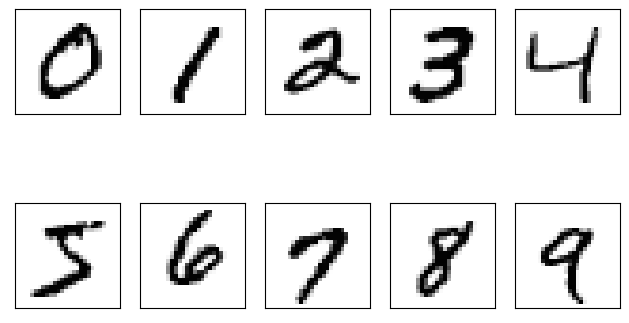

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

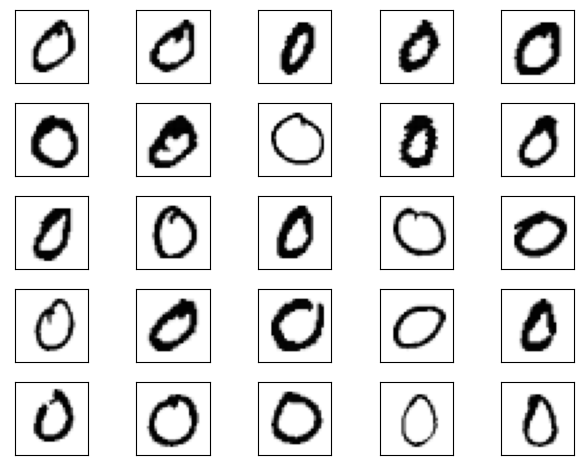

In [27]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 0][i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys')
ax[0].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

In [29]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size = 10000, random_state = 123, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 5000, random_state = 123, stratify = y_)

In [35]:
def sigmoid(z):
    return 1./(1. + np.exp(-z))

def int_to_onehot(y, nlabels):
    arr = np.zeros((y.shape[0], nlabels))
    for i, val in enumerate(y):
        arr[i, val] = 1
    return arr 

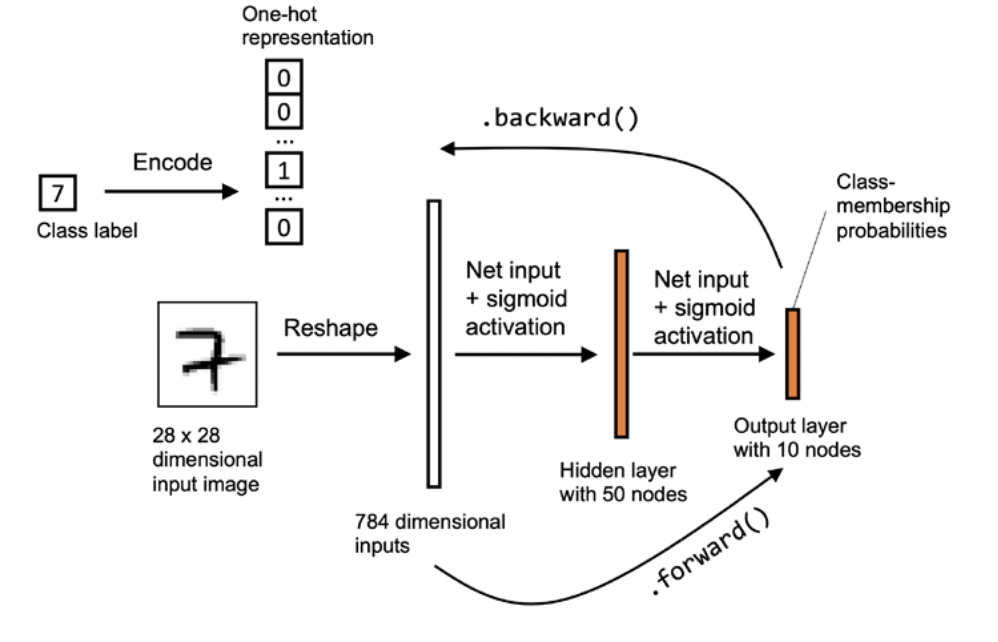

In [96]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed = 69):
        # This constructor instatiates weight matrices and bias vector for the hidden and output layers
        super().__init__()
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)
        self.weights_hidden = rng.normal(loc = 0.0, scale = 0.1, size = (num_hidden, num_features))
        self.weights_out = rng.normal(loc = 0.0, scale = 0.1, size = (num_classes, num_hidden))
        self.bias_hidden = np.zeros(num_hidden)
        self.bias_out = np.zeros(num_classes)
    
    def forward(self, x):
        # Takes data and return prediction. 
        # Returns activation of not only the output layer but also the hidden
        # We need the hidden activation during th backprop. 
        z_hidden = np.dot(x, self.weights_hidden.T) + self.bias_hidden
        activation_hidden = sigmoid(z_hidden)
        z_out = np.dot(activation_hidden, self.weights_out.T) + self.bias_out
        activation_out = sigmoid(z_out)
        return activation_hidden, activation_out
    
    def backward(self, x, activation_hidden, activation_out, y):
        # Calculates the gradients of the loss with respect to the weights and bias
        # parameters. 
        y_onehot = int_to_onehot(y, self.num_classes)
        d_loss__d_activation_out = 2. * (activation_out - y_onehot)/y.shape[0]
        d_activation_out__d_z_out = activation_out * (1. - activation_out)
        delta_out = d_loss__d_activation_out * d_activation_out__d_z_out
        d_z_out__dw_out = activation_hidden
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis = 0)
        d_z_out__activation_hidden = self.weights_out
        d_loss__activation_hidden = np.dot(delta_out, d_z_out__activation_hidden)
        d_activation_hdden__d_z_hidden = activation_hidden * (1. - activation_hidden)
        d_z_hidden__d_w_hidden = x
        d_loss__d_w_h = np.dot((d_loss__activation_hidden * d_activation_hdden__d_z_hidden).T, d_z_hidden__d_w_hidden)
        d_loss__d_b_h = np.sum((d_loss__activation_hidden * d_activation_hdden__d_z_hidden), axis = 0)
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)        
        

In [97]:
model = NeuralNetMLP(num_features = 28*28, num_hidden = 50, num_classes = 10)

In [88]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx: start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

        
# Checking minibatches shape
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print(X_train_mini.shape, y_train_mini.shape)

(100, 784) (100,)


In [89]:
def mse_loss(targets, probs, num_labels = 10):
    onehot_targets = int_to_onehot(targets, nlabels = num_labels)
    return np.mean((onehot_targets - probs) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [90]:
_, probs = model.forward(X_val)
mse = mse_loss(y_val, probs)
print(f"Initial Validation MSE: {mse: .1f}")

Initial Validation MSE:  0.2


In [91]:
predicted_labels = np.argmax(probs, axis = 1)
acc = accuracy(y_val, predicted_labels)
print(f"Initial Validation Accuracy: {acc * 100: .1f}")

Initial Validation Accuracy:  9.7


In [92]:
def compute_mse_and_acc(nnet, X, y, num_labels = 10, minibatch_size = 100):
    mse, correct_pred, num_examples = 0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis = 1)
        onehot_targets = int_to_onehot(targets, nlabels = num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc   
    

In [93]:
mse, acc = compute_mse_and_acc(model, X_val, y_val)
print(f"Initial val MSE: {mse:.1f}")
print(f"Initial val acc: {acc *100:.1f}%")

Initial val MSE: 0.2
Initial val acc: 9.7%


In [99]:
def train(model, X_train, y_train, X_val, y_val, num_epochs, learning_rate = .1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            a_hidden, a_out = model.forward(X_train_mini)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_hidden, a_out, y_train_mini)
            model.weights_hidden -= learning_rate * d_loss__d_w_h
            model.bias_hidden -= learning_rate * d_loss__d_b_h
            model.weights_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_val, y_val)
        train_acc, valid_acc = train_acc*100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f"Epoch: {e+1:03d}/{num_epochs:03d}"
             f"| Train MSE: {train_mse:.2f}"
             f"| Train Acc: {train_acc:.2f}%"
             f"| Valid Acc: {valid_acc:.2f}%")
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [100]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_val, y_val,num_epochs=50, learning_rate=0.1)

Epoch: 001/050| Train MSE: 0.03| Train Acc: 85.03%| Valid Acc: 84.72%
Epoch: 002/050| Train MSE: 0.03| Train Acc: 87.88%| Valid Acc: 87.64%
Epoch: 003/050| Train MSE: 0.02| Train Acc: 89.05%| Valid Acc: 89.16%
Epoch: 004/050| Train MSE: 0.02| Train Acc: 89.85%| Valid Acc: 89.84%
Epoch: 005/050| Train MSE: 0.02| Train Acc: 90.56%| Valid Acc: 90.38%
Epoch: 006/050| Train MSE: 0.02| Train Acc: 91.00%| Valid Acc: 90.84%
Epoch: 007/050| Train MSE: 0.02| Train Acc: 91.35%| Valid Acc: 91.10%
Epoch: 008/050| Train MSE: 0.02| Train Acc: 91.55%| Valid Acc: 91.44%
Epoch: 009/050| Train MSE: 0.01| Train Acc: 91.89%| Valid Acc: 91.60%
Epoch: 010/050| Train MSE: 0.01| Train Acc: 92.08%| Valid Acc: 91.62%
Epoch: 011/050| Train MSE: 0.01| Train Acc: 92.35%| Valid Acc: 92.16%
Epoch: 012/050| Train MSE: 0.01| Train Acc: 92.54%| Valid Acc: 92.24%
Epoch: 013/050| Train MSE: 0.01| Train Acc: 92.66%| Valid Acc: 92.38%
Epoch: 014/050| Train MSE: 0.01| Train Acc: 92.86%| Valid Acc: 92.64%
Epoch: 015/050| Trai

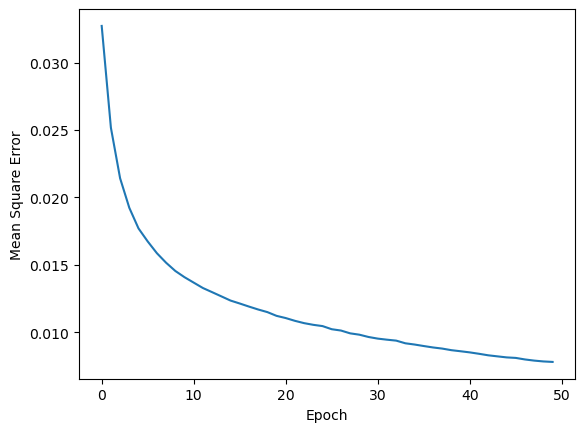

In [101]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("Mean Square Error")
plt.xlabel("Epoch")
plt.show()

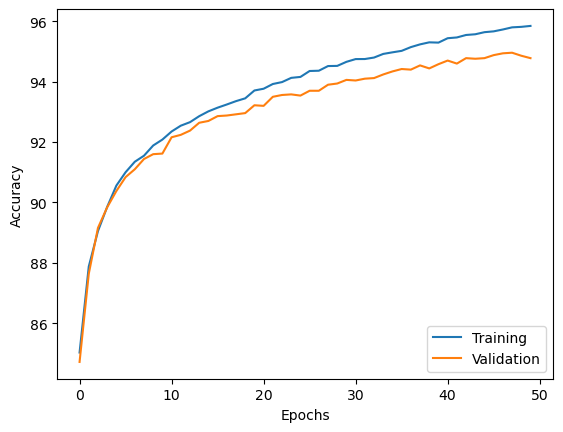

In [102]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label = 'Training')
plt.plot(range(len(epoch_train_acc)), epoch_valid_acc, label = 'Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc = 'lower right')
plt.show()

In [103]:
test_mse, test_acc = compute_mse_and_acc(model,X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}")

Test accuracy: 94.71


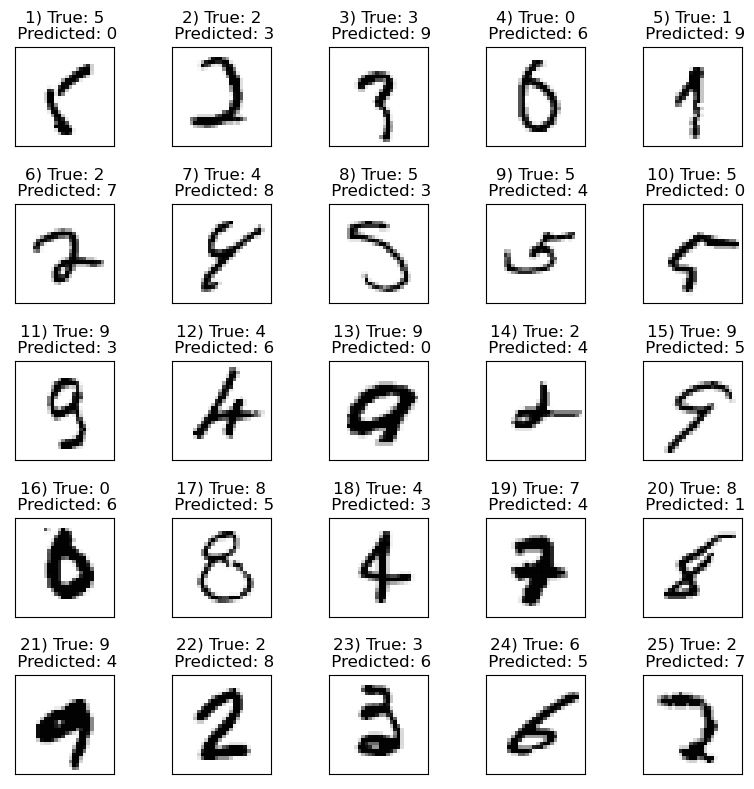

In [105]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis = 1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True, figsize = (8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
#     ax[i].set_title(f"{i+1}, True: {correct_labels[i]} Predicted: {misclassified_labels[i]}")
    ax[i].set_title(f'{i+1}) '
                f'True: {correct_labels[i]}\n'
                f' Predicted: {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()
